In [1]:
import pandas as pd

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import BeamWithSprings as bm

import ajf_plts

In [2]:
plt.style.reload_library()

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

# Calculate bridge properties
Going to be using the Shay Murtagh Y-beam data from https://www.shaymurtagh.co.uk/wp-content/uploads/2014/04/Final_Technical_Document_UK_2013_ed3.pdf

## Y-Beam Section Properties
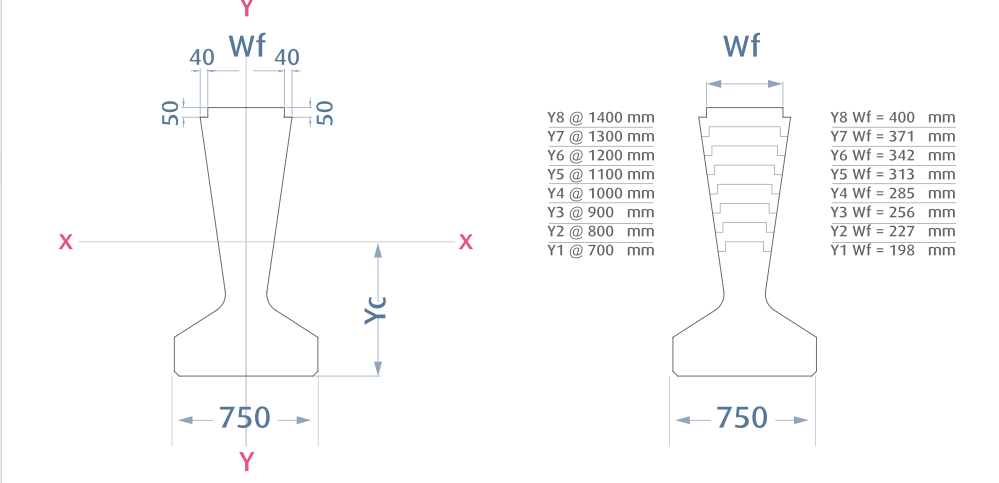

## Y-Beam Spans
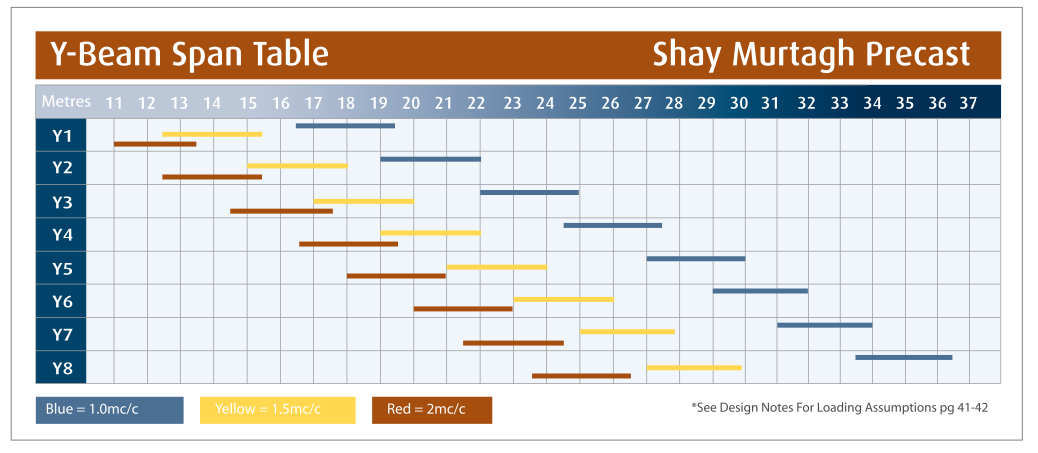

## Y-Beam Properties
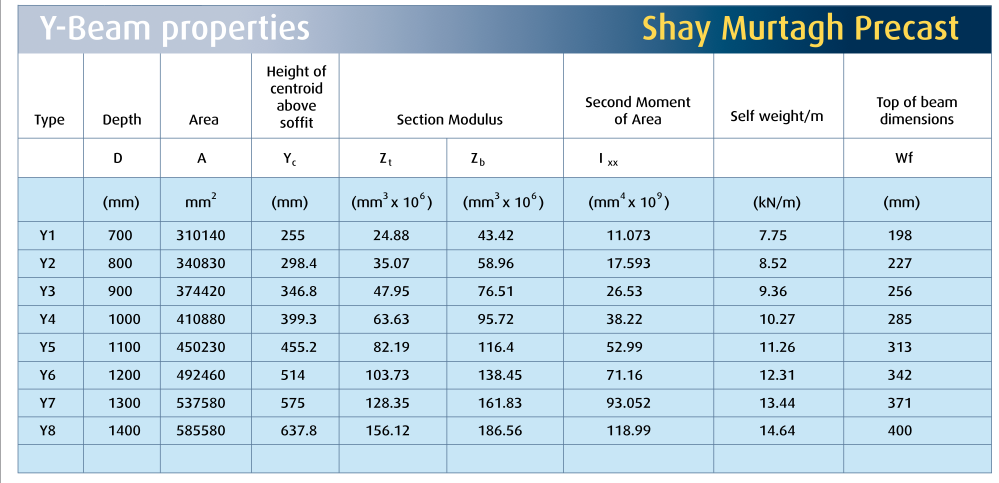

## Notes
* Need to manually cross reference with span table if bridge dimensions change
* I.e. currently using a Y6 beam for a 30m span

In [3]:
# Bridge Properties
bridge_length = 25  # m
lane_width = 3.65  # m
n_lanes = 4  # 1 lane for vehicle + 0.5 lane either side for lateral load transfer
bridge_width = n_lanes * lane_width

# Individual Y-Beam Properties
c2c = 1.5  # m, spacing centre to centre
depth_yb = 1.2  # m, y-beam depth
area_yb = 492460 / 1e6  # m^2, y beam area
cent_yb = 0.514  # m, y beam centroid
I_yb = 71.16 * 1e9 / (1e3**4)

# Slab Properties (each strip assigned to a beam)
depth_slab = 0.2  # m
area_slab = c2c * depth_slab
cent_slab = depth_slab / 2.0
I_slab = (c2c * depth_slab**3) / 12.0

# Deck Properties (Beams + Slab)
n_beams = bridge_width / c2c  # number of beams to model

depth_deck = depth_yb + depth_slab
area_deck = (area_yb + area_slab) * n_beams

# Combining beam and slab I values
cent_deck = (cent_yb * area_yb + (depth_deck - cent_slab) * area_slab) / area_deck
I_deck = (
    I_yb
    + area_yb * (cent_yb - cent_deck) ** 2
    + I_slab
    + area_slab * (cent_slab - cent_deck) ** 2
) * n_beams

# Calculating ULS for bearing
# Load Model 1 (LM1) - Clause 4.3.2 + NA.2.12
# The UK use a 300kN axle load with a uniformly distributed load of 5.5kN/m2

bridge_area = bridge_length * bridge_width
UDL = bridge_area * 5.5e3
axle = 300e3
safety_factor = 1.5
ULS_bearing = (UDL / (2 * n_beams) + axle / n_beams) * safety_factor
print("ULS for 1 bearing (kN):", ULS_bearing / 1e3)


# TODO: Update this value from bearing datasheet manually if changing bridge
k_bearing = 43 * 1e6

ULS for 1 bearing (kN): 200.92037671232882


In [4]:
# Setup beam object
n_elems = 20
elem_len = bridge_length / n_elems
beam = bm.Beam(n_elems, elem_len)

beam.density = 2400
beam.E = 30e9

beam.area = area_deck
beam.I = I_deck

beam.damp_ratio = 0.05

beam.update_model()

k_lin = k_bearing * n_beams

xi_bearing = 0.15
vert_mass = np.sum(beam.M_beam[::2, ::2]) / 2.0  # using half bridge as lump mass
# Approx natural frequency using a simply supported beam equation
wn = (np.pi / bridge_length) ** 2 * np.mean(np.sqrt(beam.E * beam.I / beam.density))
c_lin = 2.0 * xi_bearing * vert_mass * wn

n_sup_nodes = 1

for node in np.arange(n_sup_nodes):
    beam.add_springdamper_support(
        beam_node=node, k_lin=k_lin / n_sup_nodes, c_lin=c_lin / n_sup_nodes
    )
    beam.add_springdamper_support(
        beam_node=beam.N_BEAM_ELEMS - node,
        k_lin=k_lin / n_sup_nodes,
        c_lin=c_lin / n_sup_nodes,
    )

beam.update_model()

In [5]:
print("First natural frequency (Hz):", wn / (2.0 * np.pi))

First natural frequency (Hz): 11.211580470949738


In [6]:
def assemble_vehicles(veh_vel, bridge_len):
    P_2 = np.array([43.6, 29.9]) * 1000 * 2.0
    S_2 = np.array([0.0, 6.7])

    P_4 = np.array([60.0, 60.0, 100, 100]) * 1000
    S_4 = np.array([0.0, 2.15, 4.71, 6.16])

    P_5 = np.array([68670, 107910, 71613, 77499, 73575]) * 1.081
    S_5 = np.array([0.0, 3.9000, 9.7500, 11.0500, 12.3500])

    P_6 = np.array([68670, 54000, 54000, 71613, 77499, 73575])
    S_6 = np.array([0.0, 2.9, 4.2, 9.7500, 11.0500, 12.3500])

    veh_1_entry_time = 2
    veh_1_entry_dist = veh_1_entry_time * veh_vel
    veh_1_exit_time = veh_1_entry_time + (bridge_len + np.max(S_2)) / veh_vel

    veh_2_entry_time = 8
    veh_2_entry_dist = veh_2_entry_time * veh_vel
    veh_2_exit_time = veh_2_entry_time + (bridge_len + np.max(S_5)) / veh_vel

    crossing_time = bridge_len / veh_vel
    end_dist = (14.0 - crossing_time) * veh_vel

    P = np.concatenate(([0], P_2, P_5, [0]))
    S = np.concatenate(
        (
            [0],
            veh_1_entry_dist + S_2,
            veh_2_entry_dist + S_5,
            [end_dist],
        )
    )

    # patch load Eurocode 1 - Clause for really heavy axles the contact area can be assumed to be 0.4m square
    con_len = 0.4
    n_p_loads = 20

    P_con = np.repeat(P, n_p_loads) / n_p_loads
    con_sep = np.linspace(0, con_len, n_p_loads)
    S_con = np.repeat(S, n_p_loads) + np.tile(con_sep, len(P))

    return (
        P_con,
        S_con,
        con_len / n_p_loads,
        [(veh_1_entry_time, veh_1_exit_time), (veh_2_entry_time, veh_2_exit_time)],
    )


def draw_on_bridge_bg(ax, times):
    for t in times:
        ax.axvspan(t[0], t[1], lw=0.0, fc="lightgrey", zorder=-10)

In [7]:
veh_vel = 10  # metres per second

P, S, c_l, T_on_bridge = assemble_vehicles(veh_vel, bridge_length)

f_s = 1024
T_s = 1.0 / f_s

time, disp, vel, acc = beam.perform_dynamic_sim(
    P, S, veh_vel, time_step=T_s, theta=1.6, contact_length=c_l
)

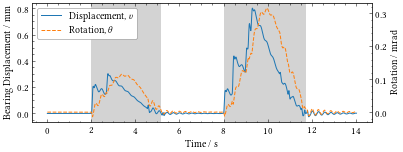

In [8]:
%matplotlib inline

sens_node = 0

theta = disp[2 * sens_node + 1, :]
v_dis = disp[2 * sens_node, :]
v_acc = acc[2 * sens_node, :]

figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax1 = plt.subplots(figsize=figsize)

ax2 = ax1.twinx()
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

l1 = ax1.plot(time, v_dis * 1000, label="Displacement, $v$")

ax1.set_ylabel("Bearing Displacement / mm")

l2 = ax2.plot(time, theta * 1000, label=r"Rotation, $\theta$")

ax2.set_ylabel("Rotation / mrad")

ax1.set_xlabel("Time / s")

draw_on_bridge_bg(ax1, T_on_bridge)

lns = l1 + l2
ax1.legend(
    lns,
    [l.get_label() for l in lns],
    loc="upper left",
).set_zorder(1)

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig3.pdf')

In [10]:
noise_df = pd.read_parquet("noise_data.parquet")[["t", "x", "z"]].set_index("t")

mu = noise_df.mean()
Sigma = noise_df.cov()


def get_ideal_acc(theta, v_acc):
    a_x = np.sin(theta) * (1 + v_acc / 9.818)  # convert into g
    a_y = np.cos(theta) * (1 + v_acc / 9.818)
    return a_x, a_y


def get_measured_sig(theta, v_acc):
    a_x, a_y = get_ideal_acc(theta, v_acc)

    n_x, n_y = np.random.default_rng().multivariate_normal(mu, Sigma, len(a_x)).T

    cross_axis = 0.02

    s_x = a_x + n_x + cross_axis * a_y
    s_y = a_y + n_y + cross_axis * a_x

    return s_x, s_y


a_x, a_y = get_ideal_acc(theta, v_acc)
s_x, s_y = get_measured_sig(theta, v_acc)

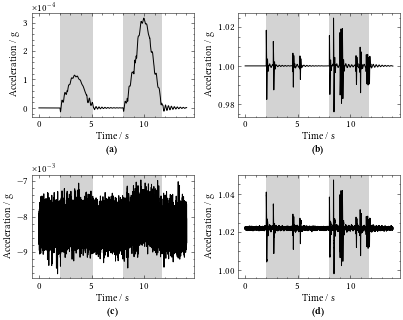

In [11]:
%matplotlib inline

figsize = (ajf_plts.text_width_inches, 2.0*ajf_plts.fig_height_inches)
fig, axs = plt.subplots(
    figsize=figsize,
    ncols=2,
    nrows=2,
    sharex=False,
    sharey=False,
)
axes = axs.ravel()

axes[0].plot(time, a_x, c='k')
axes[1].plot(time, a_y, c='k')
axes[2].plot(time, s_x, c='k')
axes[3].plot(time, s_y, c='k')

[a.set_xlabel("Time / s") for a in axs.ravel()]
[a.set_ylabel("Acceleration / g") for a in axs.ravel()]

# formatter0 = mpl.ticker.EngFormatter()
[a.ticklabel_format(axis="y", scilimits=(-2, 2)) for a in axes]

# [a.set_xticks([0, 2, 4, 6, 8, 10]) for a in axes]

[draw_on_bridge_bg(a, T_on_bridge) for a in axes]

ajf_plts.caption_axes(axes.ravel())

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig5.pdf')

In [12]:
# longest wheelbase is about 12m, shortest is around 5.7m, so a suitable trade-off is to go for 8m as this is in the middle, if you go too short, then a tractor trailer can appear as 2 separate vehicles
# don't want to go more than 13m as if there is a short headway then this might appear as one very long vehicle
v_length = 8.0  # metre
ax_length = 0.5  # metre

velocity = veh_vel  # metre per second

v_win = v_length / velocity
ax_win = ax_length / velocity

In [13]:
sim_data = pd.DataFrame(np.vstack([s_x, s_y]).T, columns=["x", "y"], index=time)
sim_data["gen_var_v"] = np.linalg.det(
    sim_data[["x", "y"]]
    .rolling(int(v_win / T_s), closed="left")
    .cov()
    .values.reshape(-1, 2, 2)
)
sim_data["gen_var_ax"] = np.linalg.det(
    sim_data[["x", "y"]]
    .rolling(int(ax_win / T_s), closed="left")
    .cov()
    .values.reshape(-1, 2, 2)
)

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


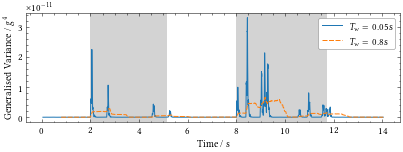

In [14]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

sim_data.gen_var_ax.plot(ax=ax, label="$T_w=" + str(ax_win) + "\mathrm{s}$")
sim_data.gen_var_v.plot(ax=ax, ls=(0, (5, 1.5)), label="$T_w=" + str(v_win) + "\mathrm{s}$")
#sim_data.gen_var_v.plot(ax=ax, label="$T_w=" + str(v_win) + "\mathrm{s}$")

draw_on_bridge_bg(ax, T_on_bridge)

ax.set_ylabel(r"Generalised Variance / $g^4$")
ax.set_xlabel("Time / s")

ax.legend()

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig8.pdf')

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


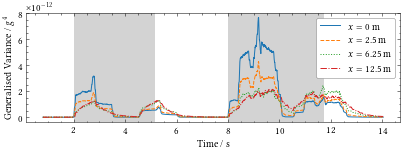

In [15]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

labels = [
    "$x=0\,\mathrm{m}$",
    "$x=2.5\,\mathrm{m}$",
    "$x=6.25\,\mathrm{m}$",
    "$x=12.5\,\mathrm{m}$",
]

for i, sens_node in enumerate([0, 2, 5, 10]):
    theta = disp[sens_node * 2 + 1, :]
    v_dis = disp[sens_node * 2, :]
    v_acc = acc[sens_node * 2, :]

    s_x, s_y = get_measured_sig(theta, v_acc)

    sim_data = pd.DataFrame(np.vstack([s_x, s_y]).T, columns=["x", "y"], index=time)
    sim_data["gen_var"] = np.linalg.det(
        sim_data[["x", "y"]].rolling(int(v_win / T_s)).cov().values.reshape(-1, 2, 2)
    )

    sim_data.gen_var.plot(ax=ax, label=labels[i])

draw_on_bridge_bg(ax, T_on_bridge)

ax.set_ylabel(r"Generalised Variance / $g^4$")
ax.set_xlabel(r"Time / s")

ax.legend()

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig9.pdf')

# this figure just shows the same 2 vehicles but the rotation is recorded at x=0....
# this shows that it is not very sensitive to sensor location but you get slightly lower responses further from bearings.

In [16]:

time, disp, vel, acc = beam.perform_dynamic_sim(
    P, S, veh_vel, time_step=T_s, theta=1.6, contact_length=c_l
)

In [17]:
disp

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.09860591e-06, 2.06645403e-06, 2.03338573e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.39985790e-07, 9.17689566e-07, 8.95002204e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.26851654e-06, 3.20861302e-06, 3.14730628e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/ajf/ajf_conda_envs/r_python310/lib

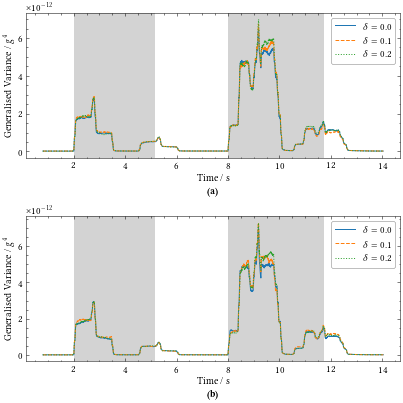

In [18]:
figsize = (ajf_plts.text_width_inches, ajf_plts.text_width_inches)
fig, axes = plt.subplots(figsize=figsize,
                         nrows=2, ncols=1)

labels = [
    "$\delta=0.0$",
    "$\delta=0.1$",
    "$\delta=0.2$",
]

sens_node = 0

for i, delta in enumerate([0.0, 0.1, 0.2]):
    beam.reset_crack_damage()
    beam.add_crack_damage(0.5 * bridge_length, delta)
    
    time, disp, vel, acc = beam.perform_dynamic_sim(
        P, S, veh_vel, time_step=T_s, theta=1.6, contact_length=c_l
    )
    
    theta = disp[sens_node * 2 + 1, :]
    v_dis = disp[sens_node * 2, :]
    v_acc = acc[sens_node * 2, :]

    s_x, s_y = get_measured_sig(theta, v_acc)

    sim_data = pd.DataFrame(np.vstack([s_x, s_y]).T, columns=["x", "y"], index=time)
    sim_data["gen_var"] = np.linalg.det(
        sim_data[["x", "y"]].rolling(int(v_win / T_s)).cov().values.reshape(-1, 2, 2)
    )

    sim_data.gen_var.plot(ax=axes[0], label=rf"$\delta={delta}$")

for i, delta in enumerate([0.0, 0.1, 0.2]):
    beam.reset_crack_damage()
    beam.add_crack_damage(0.25 * bridge_length, delta)
    
    time, disp, vel, acc = beam.perform_dynamic_sim(
        P, S, veh_vel, time_step=T_s, theta=1.6, contact_length=c_l
    )
    
    theta = disp[sens_node * 2 + 1, :]
    v_dis = disp[sens_node * 2, :]
    v_acc = acc[sens_node * 2, :]

    s_x, s_y = get_measured_sig(theta, v_acc)

    sim_data = pd.DataFrame(np.vstack([s_x, s_y]).T, columns=["x", "y"], index=time)
    sim_data["gen_var"] = np.linalg.det(
        sim_data[["x", "y"]].rolling(int(v_win / T_s)).cov().values.reshape(-1, 2, 2)
    )

    sim_data.gen_var.plot(ax=axes[1], label=labels[i])
    

for ax in axes:
    ax.set_ylabel(r"Generalised Variance / $g^4$")
    ax.set_xlabel(r"Time / s")
    ax.legend()
    draw_on_bridge_bg(ax, T_on_bridge)
    
ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figEffectOfDamage.pdf')